In [12]:
import sys
sys.path.insert(1, "./utils/")
import Stimuli, Morpho

import ctypes
import time
import argparse
import numpy as np
import pandas as pd
from neuron import nrn_dll_sym, h
from neuron.units import ms, mV

import matplotlib.pyplot as plt

import HH, Stimuli
h.load_file("stdrun.hoc")
import multiprocessing

In [127]:
# globals (yuck)
ninputs = 10

med_history = pd.DataFrame(
    {
        'v':[-66.650758],
        'm': 0.045514,
        'n': 0.353547,
        'h': 0.529801
    }
)
o_history = pd.DataFrame(
    {
        'v': [12.700157],
        'm': 0.656062,
        'n': 0.437152,
        'h': 0.395021
    }
)

excitatory_weight = 0.0002
excitatory_tau = 2
excitatory_rp = 0
inhibitory_weight = 0.0005
inhibitory_tau = 6
inhibitory_rp = -80
duration = 20

## build a test simulation

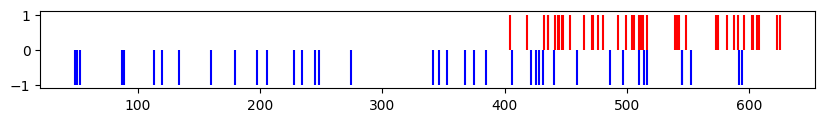

[-18.923192947575643, 2.251807052424546]

In [122]:
# generate inputs

sim_start = 49
e_stims = Stimuli.poisson_process_n(5, 40)
i_stims = Stimuli.poisson_process_n(15, 40)
stim_max = max(e_stims + i_stims)
e_stims = [-stim + stim_max + sim_start for stim in e_stims]
i_stims = [-stim + stim_max + sim_start for stim in i_stims]

plt.figure(figsize=(10,1))
plt.vlines(e_stims, 0,1,'red')
plt.vlines(i_stims, -1,0,'blue')
plt.show()

In [131]:
inputs, history, excitatory_weight, inhibitory_weight, excitatory_tau, inhibitory_tau = hh_n_inputs(100, e_stims, i_stims)
HH.run_event_sim(
    events = inputs, 
    history = history, 
    e_w = excitatory_weight, 
    i_w = inhibitory_weight, 
    e_t = excitatory_tau, 
    i_t = inhibitory_tau)

[-18.923192947575643, 2.251807052424546]

In [132]:
inputs

[('e', -34.648192947675284),
 ('i', -33.492282439957194),
 ('i', -31.22339740028019),
 ('e', -29.27913314910927),
 ('e', -23.18551561312438),
 ('e', -22.15717500521464),
 ('e', -19.171729303031043),
 ('e', -16.998250500819495),
 ('e', -2.1360844787149063),
 ('e', 0.0)]

In [136]:
hh_n_inputs(100, e_stims, i_stims)

627.3007070464321

In [84]:
events = inputs
events

[('i', -33.23278564648285),
 ('i', -32.22886084169079),
 ('e', -28.456681625588658),
 ('e', -27.389260466930295),
 ('e', -18.677237308727854),
 ('i', -15.903933263399608),
 ('e', -11.588256642759006),
 ('e', -7.753427066837162),
 ('e', -5.120540833633186),
 ('e', 0.0)]

In [85]:
shift = -min([event_time for (event_type, event_time) in events])
shift

33.23278564648285

In [87]:
sim = HH.HH()

In [91]:
sim.axon.diam

10.0

## nInputs

In [135]:
def hh_n_inputs(
        last_spike,
        e_stims,
        i_stims,
):
    # takes in inputs provided in same manor as pdt event_callback
        # event_times are positive, real-valued times from simulation, relational to the start of the simulation
    # returns the next spike time, also relational to the start of the simulation
    
    '''
    inputs = zip(
        ['o'] + ['e'] * 40 + ['i'] * 40,
        [
            last_spike,
            e0, e1, e2, e3, e4, e5, e6, e7, e8, e9, e10, e11, e12, e13, e14, e15, e16, e17, e18, e19, e20, e21, e22,
            e23, e24, e25, e26, e27, e28, e29, e30, e31, e32, e33, e34, e35, e36, e37, e38, e39,
            i0, i1, i2, i3, i4, i5, i6, i7, i8, i9, i10, i11, i12, i13, i14, i15, i16, i17, i18, i19, i20, i21, i22,
            i23, i24, i25, i26, i27, i28, i29, i30, i31, i32, i33, i34, i35, i36, i37, i38, i39
        ]
    )
    '''
    inputs = zip(
        ['o'] + ['e'] * 40 + ['i'] * 40,
        [last_spike] + e_stims + i_stims
    )
    
    inputs = sorted(inputs, key = lambda x: x[1])

    # remove infs
    inputs = [(event_type, event_time) for (event_type, event_time) in inputs if event_time != -np.inf]

    # remove events before last spike
    inputs = [(event_type, event_time) for (event_type, event_time) in inputs if event_time >= last_spike]

    # recenter event times: now they are all non-positive, where the last event received is a time t=0
    # this looks nasty but just recieves the max event_time
    last_event_time = max(enumerate(inputs), key=lambda x: x[1][1])[1][1]
    inputs = [(event_type, event_time - last_event_time) for (event_type, event_time) in inputs]
    # find the starting point of the simulation, it can be 1 of 3 choices:
        # last spike
        # nth latest input
        # first input if # inputs < n
    num_inputs = min(ninputs, len(inputs))
    inputs = inputs[-num_inputs:]
    
    

    if inputs[0][0] == 'o':
        # return the spiking history
        history = o_history
    elif (inputs[0][0] == 'e') or (inputs[0][0] == 'i'):
        history = med_history
    else:
        raise Exception('PROBLEM in the event type')
        
    #return inputs, history, excitatory_weight, inhibitory_weight, excitatory_tau, inhibitory_tau

    '''spikes = pool.starmap(
        HH.run_event_sim,
        [
            [
                inputs, history, 
                excitatory_weight, excitatory_tau, excitatory_rp,
                inhibitory_weight, inhibitory_tau, inhibitory_rp,
                duration, False
            ]
        ]
    )[0]'''
    
    spikes = HH.run_event_sim(
        inputs, history, 
        excitatory_weight, excitatory_tau, excitatory_rp,
        inhibitory_weight, inhibitory_tau, inhibitory_rp,
        duration, False
    )
    # print('recieved', spikes)
    try:
        nst = min([spike for spike in spikes if spike > 0])
        return nst + last_event_time
    except:
        return np.inf

In [ ]:
hh_n_inputs()

In [3]:
double_ptr = ctypes.POINTER(ctypes.c_double)
on_event_proto = ctypes.CFUNCTYPE(*([ctypes.c_double] * 82)) # 1 for return, 1 for last spike, 40 for each stim type

on_event_c = on_event_proto(hh_n_inputs)
on_event_c_ptr = ctypes.cast(on_event_c, double_ptr)

nrn_hocobj_ptr = nrn_dll_sym("nrn_hocobj_ptr")
nrn_hocobj_ptr.restype = ctypes.py_object
event_callback_ptr = nrn_hocobj_ptr(ctypes.cast(on_event_c_ptr, double_ptr))

In [4]:
pool = multiprocessing.Pool(1)

In [5]:
cellNST = h.nInputs40()
cellNST._ref_on_event = event_callback_ptr
cellNST_spikes = h.Vector()
cellNST_nc = h.NetCon(cellNST, None)
cellNST_nc.record(cellNST_spikes)

0.0

In [6]:
excitatory_interval = 10
excitatory_weight = 0.2
inhibitory_interval = 15
inhibitory_weight = 0.5
excitatory_tau = 2
inhibitory_tau = 2
duration = 10000
ninputs = 10

med_history = pd.DataFrame(
    {
        'v':[-66.650758],
        'm': 0.045514,
        'n': 0.353547,
        'h': 0.529801
    }
)
o_history = pd.DataFrame(
    {
        'v': [12.700157],
        'm': 0.656062,
        'n': 0.437152,
        'h': 0.395021
    }
)

In [7]:
estim = h.NetStim()
estim.noise = True
estim.interval = excitatory_interval * ms
estim.number = 10_000_000 # arbitrary
estim.start = 0 * ms
estim.seed(12)
# connect to cellNST
e_nc_nst = h.NetCon(estim, cellNST)
e_nc_nst.delay = 0
e_nc_nst.weight[0] = excitatory_weight

e_stims = h.Vector()
e_nc_nst.record(e_stims)

0.0

In [8]:
istim = h.NetStim()
istim.noise = True
istim.interval = inhibitory_interval * ms
istim.number = 10_000_000
istim.start = 0 * ms
istim.seed(113)
# connect to cellNST
i_nc_nst = h.NetCon(istim, cellNST)
i_nc_nst.delay = 0
i_nc_nst.weight[0] = -inhibitory_weight

i_stims = h.Vector()
i_nc_nst.record(i_stims)

0.0

In [ ]:
h.finitialize(-65 * mV)

start = time.perf_counter()
h.continuerun(duration * ms)
stop = time.perf_counter()

Exception ignored on calling ctypes callback function: <function hh_n_inputs at 0x7f665b8d0b80>
Traceback (most recent call last):
  File "/tmp/ipykernel_234205/1817113174.py", line 49, in hh_n_inputs
AttributeError: module 'HH' has no attribute 'run_event_sim'
Exception ignored on calling ctypes callback function: <function hh_n_inputs at 0x7f665b8d0b80>
Traceback (most recent call last):
  File "/tmp/ipykernel_234205/1817113174.py", line 49, in hh_n_inputs
AttributeError: module 'HH' has no attribute 'run_event_sim'
